# Plot sensitivity kernel at Parkfield
2023.06.27 Kurama Okubo

This notebook compute Rayleight wave depth sensitivity kernel for our frequency bands.

We use the `surf96` in the software package of  Computer programs in seismology:

Herrmann, R. B. (2013) Computer programs in seismology: An evolving tool for instruction and research, Seism. Res. Lettr. 84, 1081-1088, doi:10.1785/0220110096



In [1]:
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns 
# import importParaviewColormap
import numpy as np
import pandas as pd
import glob

import shutil
from tqdm import tqdm

import matplotlib as mpl

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

In [2]:
output_imgdir = "./figure"

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)

The depth sensitivity can be used as 

$$ \delta C(\omega) = \int \dfrac{\partial C}{\partial V_s} (z) \delta V_s (z) dz. $$

See [1]	Fang, H., Yao, H., Zhang, H., Huang, Y.-C., and van der Hilst, R. D. Direct inversion of surface wave dispersion for three-dimensional shallow crustal structure based on ray tracing: methodology and application. Geophys. J. Int., 201(3):1251-1263, 2015, doi:10.1093/gji/ggv080.

Thus, $\partial C(\omega) / \partial V_s (z)$ provides which depth contributes more to the observed phase velocity change at given frequency.

# 1D structure at Parkfield

We downloaded the 1D structure model from the SCEC Unified Community Velocity Model (UCVM)

http://moho.scec.org/UCVM_web/web/viewer.php

Note that the latlon of the Parkfield is: 35.89976042810284, -120.43258794236007 at Parkfield lodge.

~~We selected the CVM-S4.26.M01 and CCA, and use the former one as the standard SCEC velocity model.~~

We use the CVM-H v15.1.1.

https://www.scec.org/research/cvm

In [3]:
finame = "UCVM_25408471_v_data.csv"
df_struct = pd.read_csv(f"./data/{finame}", header=7, names=["Depth(m)", "Vp(m/s)", "Vs(m/s)", "Density(kg/m^3)"])

In [4]:
df_struct

,Depth(m),Vp(m/s),Vs(m/s),Density(kg/m^3)
0,0,4696.080,2306.589,2489.757
1,50,4696.080,2306.589,2489.757
2,100,4695.749,2304.686,2489.709
3,150,4695.749,2304.686,2489.709
4,200,4697.251,2305.400,2489.924
...,...,...,...,...
196,9800,5758.243,2940.719,2666.867
197,9850,5758.243,2940.719,2666.867
198,9900,5765.237,2944.067,2668.250
199,9950,5765.237,2944.067,2668.250


In [5]:
df_struct["d"] = df_struct["Depth(m)"].mul(1e-3)
df_struct["vp"] = df_struct["Vp(m/s)"].mul(1e-3)
df_struct["vs"] = df_struct["Vs(m/s)"].mul(1e-3)
df_struct["rho"] = df_struct["Density(kg/m^3)"].mul(1e-3)

In [6]:
del_depth = df_struct["d"][1] - df_struct["d"][0] # [km] step of depth 
del_depth

0.05

In [7]:
df_struct["d"]

0       0.00
1       0.05
2       0.10
3       0.15
4       0.20
       ...  
196     9.80
197     9.85
198     9.90
199     9.95
200    10.00
Name: d, Length: 201, dtype: float64

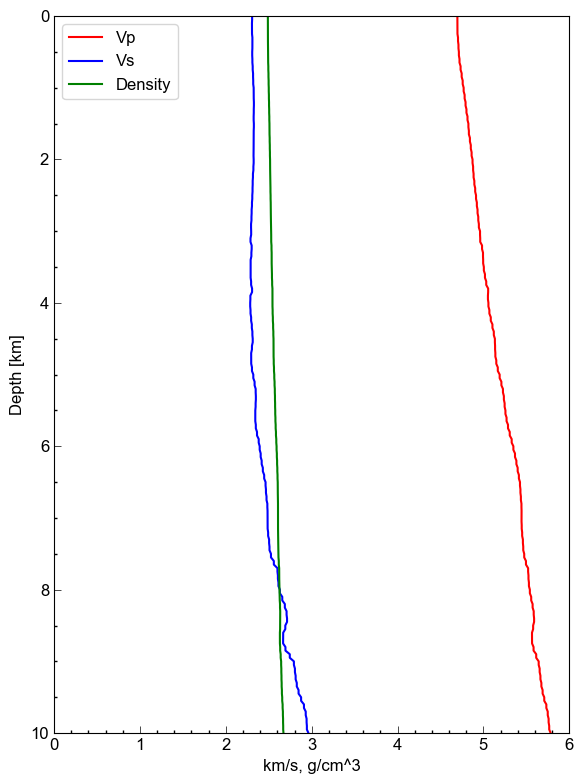

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

ax.plot(df_struct["vp"], df_struct["d"],"r-", label="Vp")
ax.plot(df_struct["vs"], df_struct["d"],"b-", label="Vs")
ax.plot(df_struct["rho"], df_struct["d"],"g-", label="Density")
ax.set_xlim([0, 6])
ax.set_ylim([0, 10])
plt.gca().invert_yaxis()
ax.legend(loc=0)
ax.set_xlabel("km/s, g/cm^3")
ax.set_ylabel("Depth [km]")

fig.tight_layout()
foname = (output_imgdir+f"/structure_Parkfield1D_CVM.png")
plt.savefig(foname, dpi=300, bbox_inches='tight')

In [9]:
# make the model96.dat file
fo = open("./data/model_Parkfield1D_CVM.dat", "w")

fo.write("MODEL.01\nPARKFIELD1D\nISOTROPIC\nKGS\nFLAT EARTH\n1-D\nCONSTANT VELOCITY\nLINE08\nLINE09\nLINE10\nLINE11\nH VP VS RHO QP QS ETAP ETAS FREFP FREFS\n")
Qp = 0
Qs = 0


for i in range(len(df_struct)-1):
    df_struct0 = df_struct.iloc[i]
    df_struct1 = df_struct.iloc[i+1]
    vp_avg = (df_struct0["vp"] + df_struct1["vp"])/2
    vs_avg = (df_struct0["vs"] + df_struct1["vs"])/2
    rho_avg = (df_struct0["rho"] + df_struct1["rho"])/2
    fo.write(f"{del_depth:.2f} {vp_avg:.2f} {vs_avg:.2f} {rho_avg:.2f} {Qp} {Qs} 0 0 1.0 1.0\n")
    
fo.close()

# Compute the depth sensitivity using sdpder96

## NOTE: Unit of depth sensitivity

To synchronize the unit to Wu et al. (2016), we need to multiply $10^1$ as follows. 
The unit of system in sdpder96 is in KGS. That is

$$ \delta c \text{[km/s]} = \int  \dfrac{\partial C}{\partial V_s} \delta v_s(z) \text{[km/s]}dz.$$

Convert from [km] to [m] gives

$$ \delta c \text{[m/s]} = \int  \dfrac{\partial C}{\partial V_s} \delta v_s(z) \text{[m/s]} \times 10^3 dz.$$


The change of velocity with depth is written as following:

$$  \delta v_s(z)\text{[m/s]} = \dfrac{dv}{v}\text{[%]} \times 10^{-2} \times v_s^0\text{[m/s]}, $$
where the $v_s^0$ is the reference velocity. Substitute this to the equation above, we obtain 

$$ \delta c \text{[m/s]} = \int \dfrac{\partial C}{\partial V_s} \dfrac{dv}{v}\text{[%]} \times 10^{-2} \times v_s^0\text{[m/s]} \times 10^3 dz.$$

$$ =  \int \left( \dfrac{\partial C}{\partial V_s} \times 10^1 \right) \dfrac{dv}{v}\text{[%]} \times v_s^0\text{[m/s]} dz.$$

Thus, we multiply the scaling factor of $10^1$ to use the dv/v in [%] and velocity in [m/s].


In [10]:
freqbands = [0.2, 0.5, 0.9, 1.2, 2.0]
mfreqs = []
for i in range(len(freqbands)-1):
    mfreqs.append((freqbands[i] + freqbands[i+1])/2)

print(f"target freq: {mfreqs}[Hz]")
print(f"target period:{1/np.array(mfreqs)} [s]")

# write the list of DT for the input command line of sprep96
target_DT=1/np.array(mfreqs)/2
print(f"for dt in {np.round(target_DT, 8)}")

target freq: [0.35, 0.7, 1.05, 1.6][Hz]
target period:[2.85714286 1.42857143 0.95238095 0.625     ] [s]
for dt in [1.42857143 0.71428571 0.47619048 0.3125    ]


__Please compile the package and run the ./code/runit_depthsensitivity_Parkfield.sh at this stage__ to compute the depth sensitivity.

In [11]:
# Compute the center of layers at depth
dep_vec = (df_struct["d"].values + del_depth/2)[:-1]
Ndep = len(dep_vec)

In [12]:
# Read the table in text file for the depth sensitivity 
dcdb_scaling_factor = 10.0
Nheader = 208 #108

dcdb_all = dict()
for i, dt in enumerate(1/np.array(mfreqs)/2):
    freqband = f"{freqbands[i]}-{freqbands[i+1]}Hz"
    print(freqband)
    finame = f"./code/SRDER_DT{np.round(target_DT[i], 8)}.TXT"
    df_srder=pd.read_csv(finame, delim_whitespace=True, header=Nheader, nrows=Ndep, skip_blank_lines=False, index_col=0)
    dcdb_all[freqband] = df_srder["DC/DB"].values*dcdb_scaling_factor
    # check frequency in the output of sdpder96
    f = open(finame)
    content = f.readlines()
    freq_check = round(1/float(content[Nheader-2].split("C")[0].split("=")[-1]), 3)
    f.close()
    print(freq_check)

0.2-0.5Hz
0.35
0.5-0.9Hz
0.7
0.9-1.2Hz
1.05
1.2-2.0Hz
1.6


# Plot the depth sensitivity

In [13]:
lc = plt.cm.viridis(np.linspace(0, 0.9, len(dcdb_all)))
lc

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.206756, 0.371758, 0.553117, 1.      ],
       [0.134692, 0.658636, 0.517649, 1.      ],
       [0.741388, 0.873449, 0.149561, 1.      ]])

In [14]:
# maxid = np.argmax(dcdb_all[freqband])
# halfid = maxid + np.where(dcdb_all[freqband][maxid:] <= 0.5*dcdb_all[freqband][maxid])[0][0]
# dcdb_all[freqband][halfid]

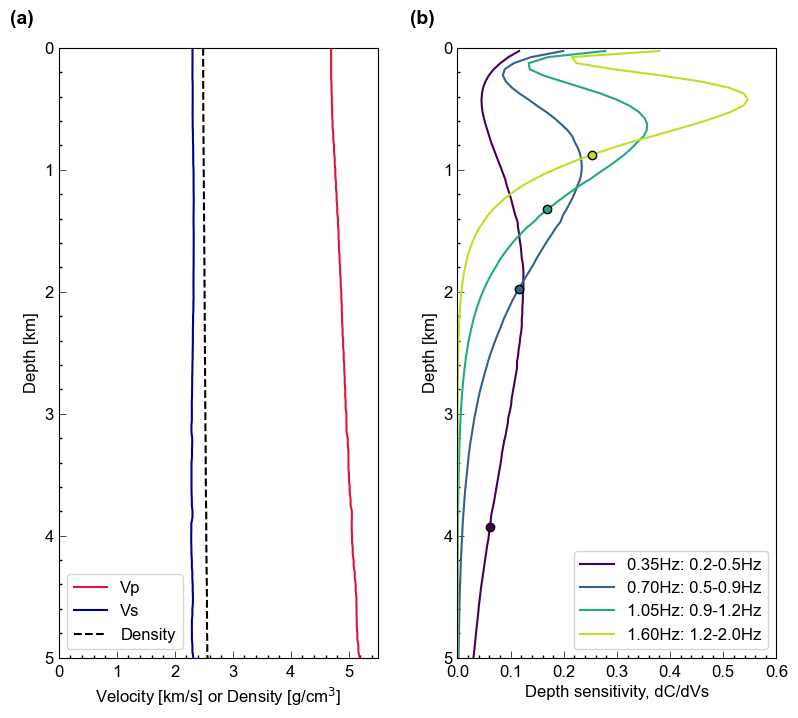

In [15]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(8,7))

# velocity profile
axs[0].plot(df_struct["vp"], df_struct["d"],"-", c="crimson", label="Vp")
axs[0].plot(df_struct["vs"], df_struct["d"],"-", c="darkblue", label="Vs")
axs[0].plot(df_struct["rho"], df_struct["d"],"k--", label="Density")
axs[0].set_xlim([0, 5.5])
axs[0].set_ylim([0, 5])
axs[0].legend(loc=3)
axs[0].set_xlabel("Velocity [km/s] or Density [g/cm$^3$]")
axs[0].set_ylabel("Depth [km]")
axs[0].invert_yaxis()

# depth sensitivity
for i in range(len(freqbands)-1):
    freqband = f"{freqbands[i]}-{freqbands[i+1]}Hz"
    axs[1].plot(dcdb_all[freqband], dep_vec, label=f"{mfreqs[i]:.2f}Hz: {freqband}", c=lc[i])
    # plot half amplitude at depth
    maxid = np.argmax(dcdb_all[freqband])
    halfid = maxid + np.where(dcdb_all[freqband][maxid:] <= 0.5*dcdb_all[freqband][maxid])[0][0]
    axs[1].plot(dcdb_all[freqband][halfid], dep_vec[halfid], "o", ms=6, markerfacecolor=lc[i], markeredgecolor="k")
        
axs[1].legend(loc=4)
axs[1].set_xlabel("Depth sensitivity, dC/dVs")
axs[1].set_ylabel("Depth [km]")
axs[1].set_xlim([0, 0.6])
axs[1].set_ylim([0, 5])
axs[1].invert_yaxis()
fig.tight_layout()
axs[0].tick_params(axis='x', pad=5)
axs[1].tick_params(axis='x', pad=5)

plt.subplots_adjust(wspace=0.25)

plt.text(0.005, 1.0, "(a)", fontsize=14, fontweight="bold", transform=plt.gcf().transFigure)
plt.text(0.505, 1.0, "(b)", fontsize=14, fontweight="bold", transform=plt.gcf().transFigure)

foname = (output_imgdir+f"/depthsensitivity_Parkfield_master.png")
plt.savefig(foname, dpi=300, bbox_inches='tight')

# Conclusion

We obtained the Rayleigh wave depth sensitivity kernel to show the frequency band of 0.9-1.2 Hz corresponds to the velocity change at ~1km depth.